In [145]:
import numpy as np
from scipy.optimize import least_squares
from matplotlib import pyplot as plt

from sklearn.gaussian_process.kernels import RBF, Matern
import h5py

source_dataset = "../Datasets/Dataset_forumtracking.hdf5"
final_dataset = "forumtracking.hdf5"

origin = "4"

max_trajectory_length = 100
max_nr_trajectories = 100
filter_parameter = ("", 3)
goals = [el for el in range(1,9)]
!pip install shapely

%run preprocessing.py

# defines:
# filter_by_origin(path, goal, target=None)
# filter_by_length(path, length, target=None)
# filter_by_number(path, number, target=None)
# filter_trajectory(data, kind=None, windowsize=3)
# adjust_trajectory_length(trajectory, length)
# dp_algorithm(tolerance, trajectory)
# dp_cost_function(tolerance, trajectory)
# process_trajectory(trajectory, length, filter_parameter)

distributed 1.21.8 requires msgpack, which is not installed.


In [9]:
#img_forum = cv2.imread("../Datasets/Images/forumtracking.png")

i = 0
with h5py.File(final_dataset, "r") as f:
    count_total = f.attrs["TotalNrTrajectories"]
    X_forum = np.zeros((count_total, max_trajectory_length,2))
    y_forum = np.zeros((count_total,))
    for goal in f:
        for traj in f[goal]:
            trajectory = process_trajectory(f[goal+"/"+traj+"/Positions"][:], \
                                                  max_trajectory_length, \
                                                  filter_parameter)
            X_forum[i] = trajectory
            y_forum[i] = int(goal)
            i += 1

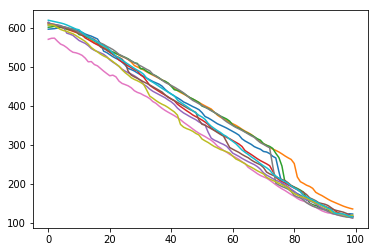

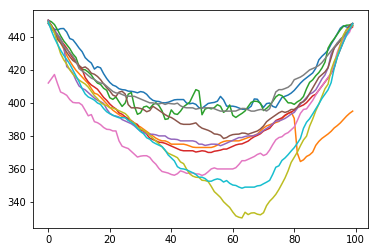

In [183]:
data = X_forum[1000:1010,:,:]

for traj in data:
    plt.plot(traj[:,0])
plt.show()
for traj in data:
    plt.plot(traj[:,1])
plt.show()

# Mean & Variance

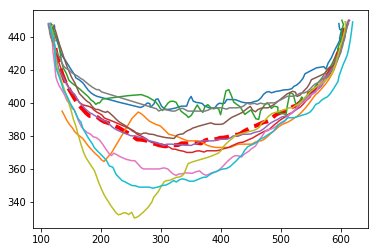

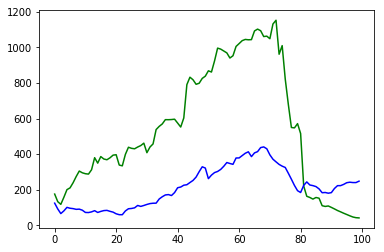

In [167]:
mx = np.mean(data[:,:,0],axis=0)
my = np.mean(data[:,:,1],axis=0)
plt.plot(mx,my,linewidth=4,linestyle="--",c="r")
for traj in data:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

real_x_std = np.var(data[:,:,0],axis=0)
real_y_std = np.var(data[:,:,1],axis=0)

plt.plot(real_x_std,c="g")
plt.plot(real_y_std,c="b")
plt.show()

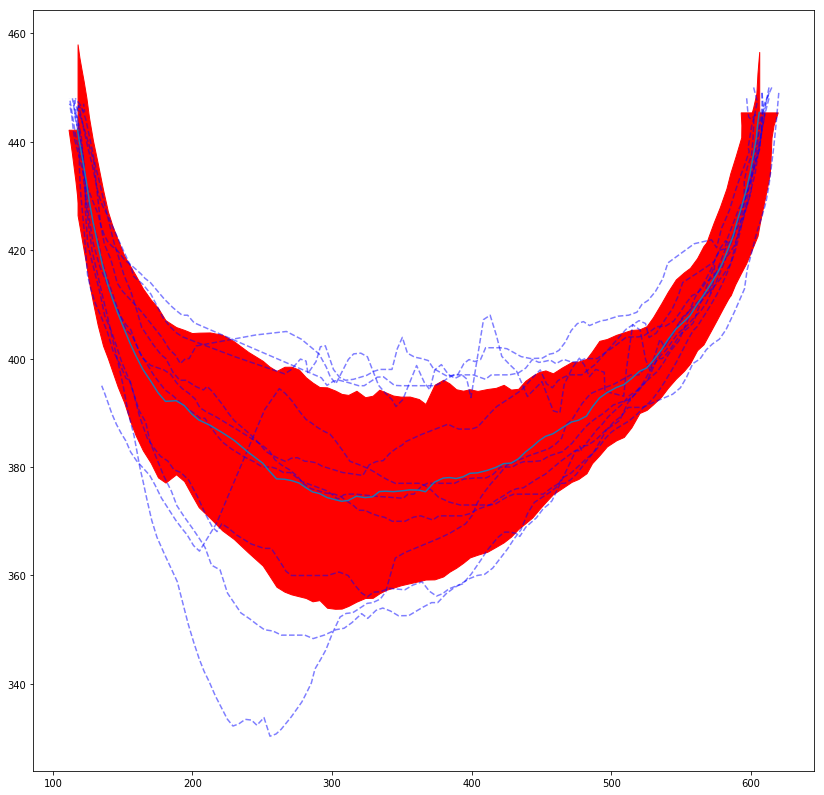

In [168]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

for traj in data:
    ax.plot(traj[:,0], traj[:,1],c="b",linestyle="--",alpha=0.5)
ax.plot(mx,my)
ax.fill_between(mx,  my - np.sqrt(real_y_std), my + np.sqrt(real_y_std), alpha=1, color='r')
ax.fill_betweenx(my, mx - np.sqrt(real_x_std), mx + np.sqrt(real_x_std) , alpha=1, color='r')
#ax.fill_between(mx-np.sqrt(real_x_std), my - np.sqrt(real_y_std), my + np.sqrt(real_y_std), alpha=1, color='r')
plt.show()

1.0


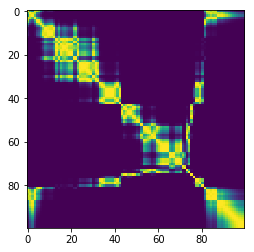

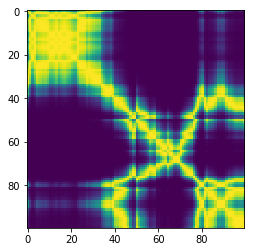

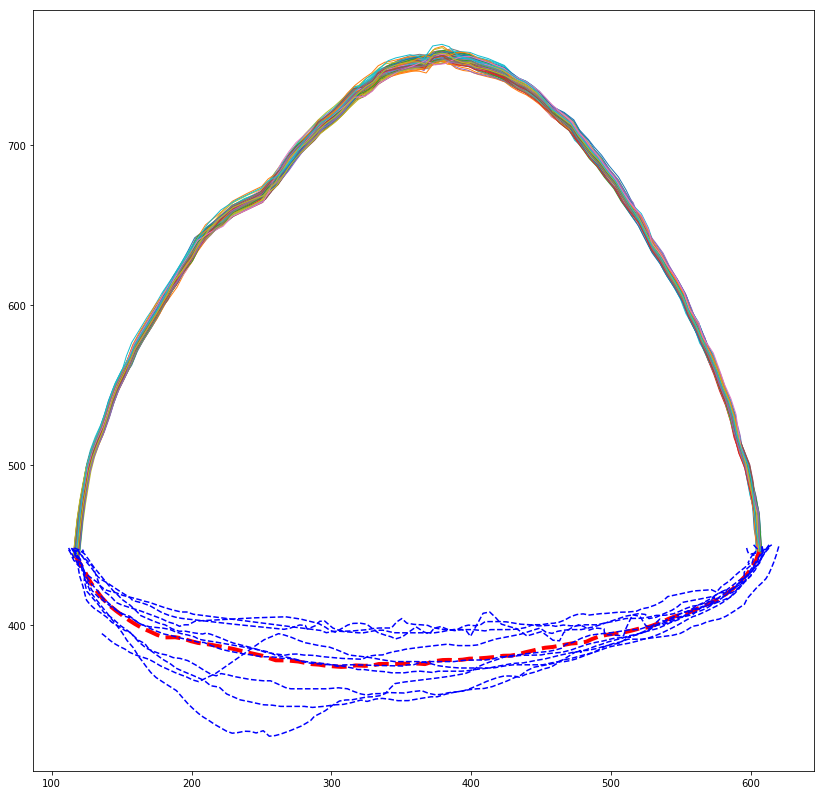

In [179]:
scale_x = 1
scale_y = 1
ls_x, ls_y = 50, 50

kx = RBF(length_scale=ls_x)(real_x_std.reshape(100,1))*scale_x
ky = RBF(length_scale=ls_y)(real_y_std.reshape(100,1))*scale_y
print(np.max(kx))
plt.imshow(kx)
plt.show()
plt.imshow(ky)
plt.show()

n_samples = 100
x_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)*(np.sin(np.linspace(0,np.pi,100))+1)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
for i in range(n_samples):
    ax.plot(x_samples[i], y_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")

for traj in data:
    plt.plot(traj[:,0], traj[:,1],c="b",linestyle="--")
    
    
plt.show()



# Allgemeine Varianz


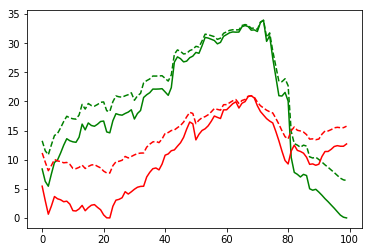

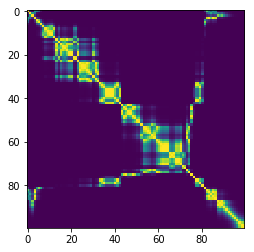

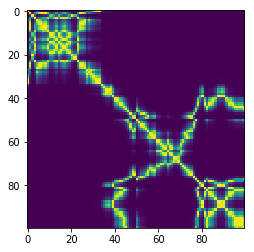

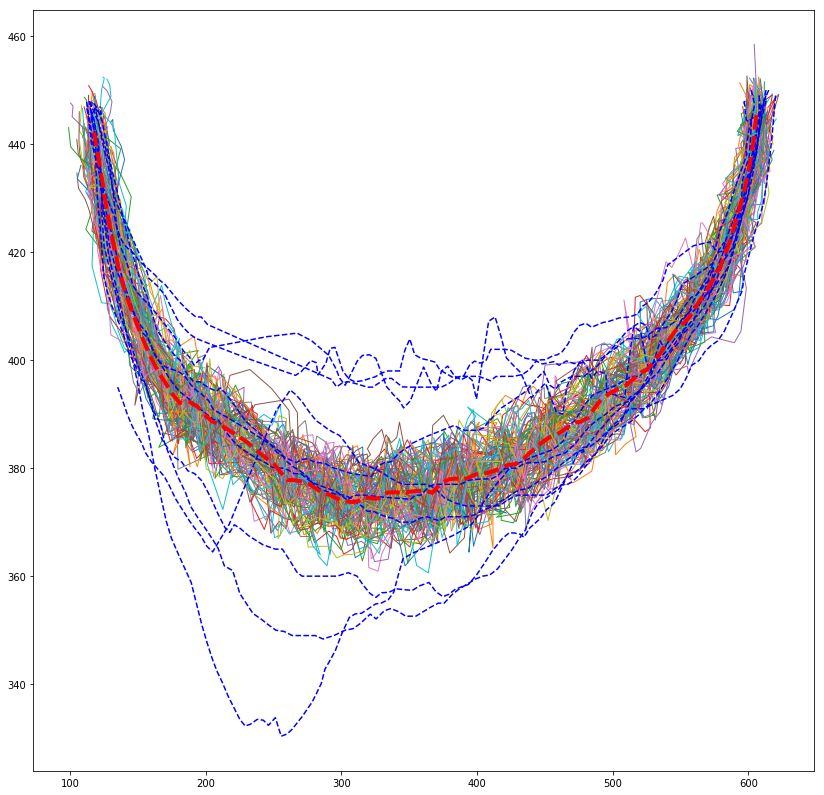

(100,)


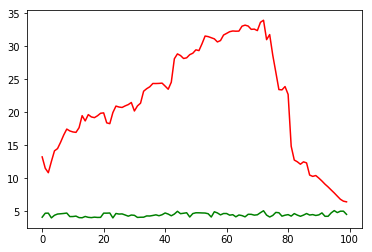

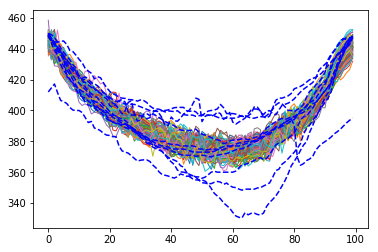

In [137]:
#x_std = np.load("x_std_mean.npy")
#y_std = np.load("y_std_mean.npy")
x_std = real_x_std
y_std = real_y_std

ls_x, ls_y = 1, 1
scale_x, scale_y = np.max(x_std), np.max(y_std)

plt.plot(x_std,c="g",linestyle="--")
x_std = (x_std-np.min(x_std))/(np.max(x_std)-np.min(x_std))*np.max(x_std)
plt.plot(x_std,c="g")
plt.plot(y_std,c="r",linestyle="--")
y_std = (y_std-np.min(y_std))/(np.max(y_std)-np.min(y_std))*np.max(y_std)
plt.plot(y_std,c="r")
plt.show()


#kx = RBF(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
#ky = RBF(length_scale=ls_y)(y_std.reshape(100,1))*scale_y
kx = Matern(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
ky = Matern(length_scale=ls_y)(y_std.reshape(100,1))*scale_y

plt.imshow(kx)
plt.show()
plt.imshow(ky)
plt.show()

n_samples = 100
x_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
for i in range(n_samples):
    ax.plot(x_samples[i], y_samples[i], linewidth=1)
for traj in data:
    plt.plot(traj[:,0], traj[:,1],c="b",linestyle="--")
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")

plt.show()
print(np.std(data[:,:,0],axis=0).shape)
plt.plot(np.std(data[:,:,0],axis=0),c="r")
plt.plot(np.std(y_samples,axis=0),c="g")
plt.show()

for i in range(n_samples):
    plt.plot(y_samples[i], linewidth=1)
for traj in data:
    plt.plot(traj[:,1],c="b",linestyle="--")
plt.show()

# Unterschiedliche Kernels


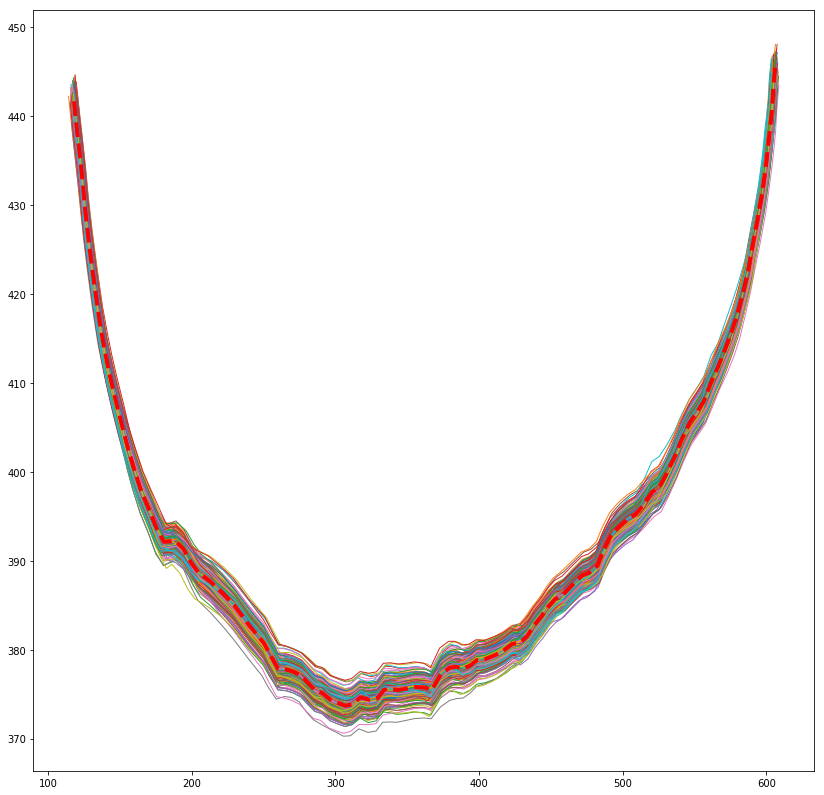

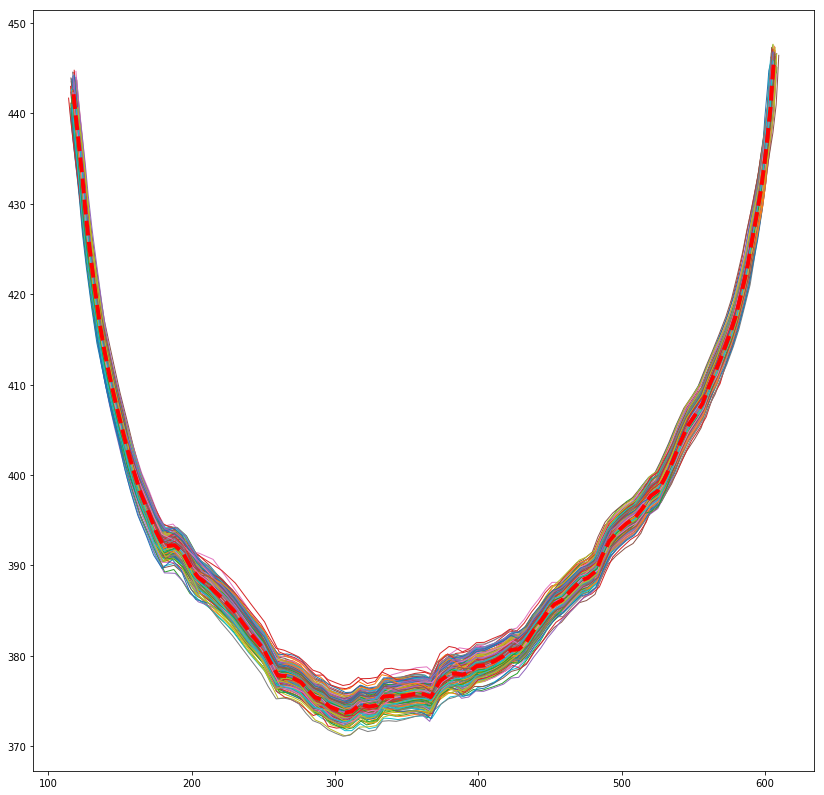

In [91]:
x_std = np.load("x_std_mean.npy")
y_std = np.load("y_std_mean.npy")

n_samples = 200
ls_x, ls_y = 5, 5
scale = 1

kx = RBF(length_scale=ls_x)(std_x.reshape(100,1))*scale
ky = RBF(length_scale=ls_y)(std_y.reshape(100,1))*scale


x_rbf_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_rbf_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)


for i in range(n_samples):
    ax.plot(x_rbf_samples[i], y_rbf_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")
plt.show()

kx = Matern(length_scale=ls_x)(std_x.reshape(100,1))*scale
ky = Matern(length_scale=ls_y)(std_y.reshape(100,1))*scale


x_mat_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_mat_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)

for i in range(n_samples):
    ax.plot(x_mat_samples[i], y_mat_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")
plt.show()

(100,)
(200, 100)


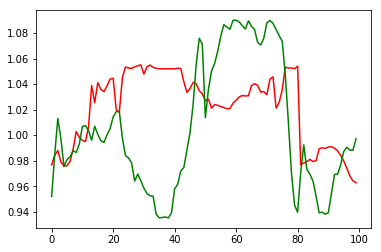

In [95]:
print(np.std(x_rbf_samples,axis=0).shape)
#plt.plot(x_std,c="g")
print(x_rbf_samples.shape)
plt.plot(np.std(x_rbf_samples,axis=0),c="r")
plt.plot(np.std(y_rbf_samples,axis=0),c="g")
plt.show()

# Find optimal Parameters

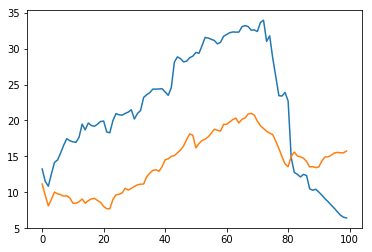

In [142]:
plt.plot(real_x_std)
plt.plot(real_y_std)
plt.show()

In [149]:
x0 = np.array([5.0, 5.0, 35, 20], dtype=float)
bounds = ([1e-9,1e-9,1e-1,1e-1], [2e2,2e2,1e2,1e2])

def to_minimize(x):
    ls_x, ls_y, scale_x, scale_y = x

    #x_std = (real_x_std-np.min(real_x_std))/(np.max(real_x_std)-np.min(real_x_std))*scale_x
    #y_std = (real_y_std-np.min(real_y_std))/(np.max(real_y_std)-np.min(real_y_std))*scale_y
    x_std = real_x_std
    y_std = real_y_std

    #kx = RBF(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
    #ky = RBF(length_scale=ls_y)(y_std.reshape(100,1))*scale_y
    kx = Matern(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
    ky = Matern(length_scale=ls_y)(y_std.reshape(100,1))*scale_y

    n_samples = 250
    x_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
    y_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

    new_x_std = np.std(x_samples,axis=0)
    new_y_std = np.std(y_samples,axis=0)
    return np.max([np.linalg.norm(real_x_std-new_x_std), np.linalg.norm(real_y_std-new_y_std)])
    
test = to_minimize(np.array([2,2,10,10]))
print(test)

res = least_squares(fun=to_minimize,x0=x0)#, bounds=bounds)
print(res)

202.1367993158753
 active_mask: array([0., 0., 0., 0.])
        cost: 13734.346168860604
         fun: array([165.73681648])
        grad: array([1.11854795e+09, 1.43999415e+09, 1.87955611e+09, 3.41327612e+09])
         jac: array([[ 6748940.7213985 ,  8688438.59025159, 11340607.03682614,
        20594555.80458818]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 15
        njev: 6
  optimality: 3413276115.921606
      status: 3
     success: True
           x: array([26.11011837, 45.42409849, 46.20602019, 18.7521488 ])


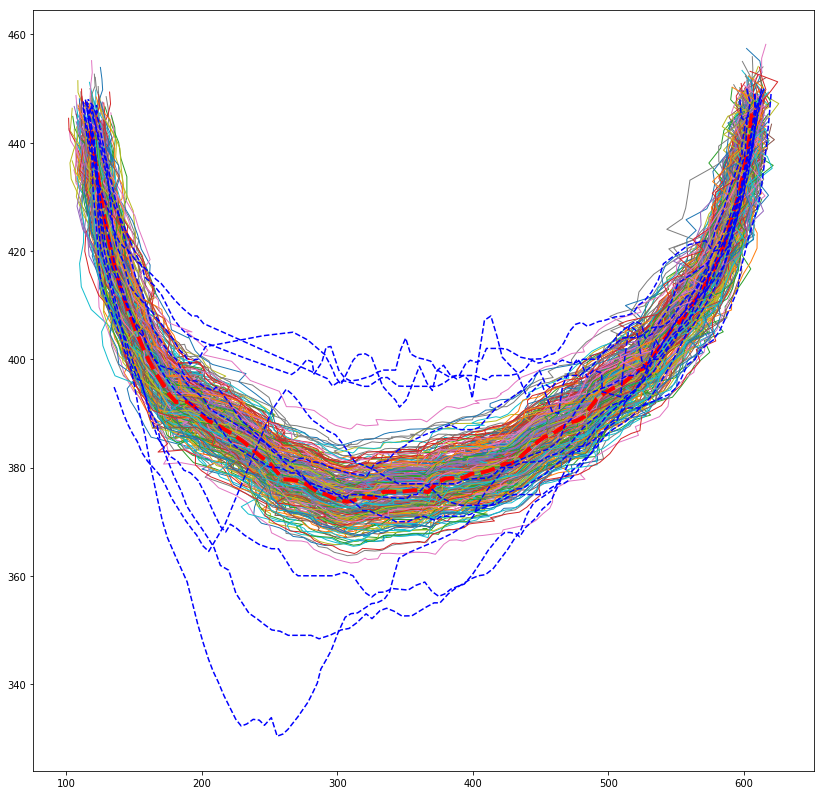

In [152]:
x_std = real_x_std
y_std = real_y_std

n_samples = 200
s_x, ls_y, scale_x, scale_y = res.x

kx = Matern(length_scale=ls_x)(x_std.reshape(100,1))*scale_x
ky = Matern(length_scale=ls_y)(y_std.reshape(100,1))*scale_y

n_samples = 250
x_samples = np.random.multivariate_normal(mean=mx, cov=kx, size=n_samples)
y_samples = np.random.multivariate_normal(mean=my, cov=ky, size=n_samples)

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)


for i in range(n_samples):
    ax.plot(x_samples[i], y_samples[i], linewidth=1)
ax.plot(mx,my,linewidth=4,linestyle="--",c="r")

for traj in data:
    ax.plot(traj[:,0],traj[:,1],c="b",linestyle="--")
    
plt.show()
